## Solve a life-cycle consumption/saving problem 

- This notebook reproduces the life cycle consumption model by Gourinchas and Parker 2002 

  - CRRA utility 
  - No bequest motive
  - During work: labor income risk: permanent + transitory/unemployment 
  - During retirement: no risk



In [1]:
import numpy as np
import pandas as pd
from quantecon.optimize import brent_max, brentq
from interpolation import interp, mlinterp
from scipy import interpolate
import numba as nb
from numba import njit, float64, int64, boolean,jitclass
import matplotlib as mp
import matplotlib.pyplot as plt
%matplotlib inline
from quantecon import MarkovChain
import quantecon as qe 

In [2]:
## figures configurations

mp.rc('xtick', labelsize=14) 
mp.rc('ytick', labelsize=14) 

fontsize = 14
legendsize = 12

## The Model Class and Solver

In [3]:
lc_data = [
    ('ρ', float64),              # utility parameter CRRA
    ('β', float64),              # discount factor
    ('R',float64),               # Nominal interest rate factor 
    ('P', float64[:, :]),        # transition probs for z_t        x
    ('z_val', float64[:]),       # values of z                     x
    #('a_s', float64),           # preference volatility        x 
    #('sigma_s', float64),        # loading of macro state to preference    x
    
    ('sigma_n', float64),         # permanent shock volatility              x
    ('b_y', float64),            # loading of macro state to income
    ('sigma_u', float64),        # transitory shock volatility
    ('U',float64),               # the probability of being unemployed    * 
    ('s_grid', float64[:]),      # Grid over savings
    ('n_shk_draws', float64[:]),   ## Draws of permanent income shock for MC
    ('u_shk_draws', float64[:]),   # Draws of transitory income shock for MC
    ('ue_shk_draws',boolean[:]),     # Draws of unemployment shock 
    #('ζ_draws', float64[:])      # Draws of preference shock ζ for MC
    ('T',int64),                 # years of work                          *   
    ('L',int64),                 # years of life                          * 
    ('G',float64)             # growth rate of permanent income    * 
]

In [4]:
@jitclass(lc_data)
class LifeCycle:
    """
    A class that stores primitives for the life cycle consumption
    problem.
    """

    def __init__(self,
                 ρ = 2,
                 β = 0.96,
                 P = np.array([(0.9, 0.1),
                             (0.1, 0.9)]),
                 z_val = np.array([1.0,2.0]), 
                 #a_s = 0.02,     ## size of the taste shock  
                 #b_s = 0.0,   ## coefficient of pandemic state on taste 
                 sigma_u = 0.2,     ## size of transitory income risks
                 U = 0.01,          ## unemployment risk 
                 b_y = 0.0,         ## loading of macro state on income 
                 sigma_n = 0.15,     ## size of permanent income shocks
                 R = 1.03,
                 T = 40,             ## work age, from 25 to 65
                 L = 60,             ## life length 85
                 G = 1.0,            ## growth rate of permanent income 
                 shock_draw_size = 50,
                 grid_max = 2.5,
                 grid_size = 100,
                 seed = 1234):

        np.random.seed(seed)  # arbitrary seed

        self.ρ, self.β = ρ, β
        
        self.R = R 
        self.sigma_u, self.b_y = sigma_u, b_y
        self.sigma_n = sigma_n
        
        self.n_shk_draws = sigma_n*np.random.randn(shock_draw_size)-sigma_n**2/2
        self.u_shk_draws = sigma_u*np.random.randn(shock_draw_size)-sigma_u**2/2
        self.ue_shk_draws = np.random.uniform(0,1,shock_draw_size)<U

        self.s_grid = np.exp(np.linspace(np.log(1e-6), np.log(grid_max), grid_size))
        # This creates an unevenly spaced grids where grids are more dense in low values
        
        self.P, self.z_val = P, z_val
        self.G = G
        self.T,self.L = T,L
        # Test stability assuming {R_t} is IID and adopts the lognormal
        # specification given below.  The test is then β E R_t < 1.
        #ER = np.exp(b_r + a_r**2 / 2)
        assert β * R < 1, "Stability condition failed."

    # Marginal utility
    def u_prime(self, c):
        return c**(-self.ρ)

    # Inverse of marginal utility
    def u_prime_inv(self, c):
        return c**(-1/self.ρ)

    #def ϕ(self, z, ζ):
    #    ## preference 
    #    return np.exp(self.sigma_s * ζ + (z*self.b_s))

    def Y(self, z, u_shk):
        ## income 
        return np.exp(u_shk + (z * self.b_y))
    
    def Γ(self,n_shk):
        return np.exp(n_shk)

In [5]:
@njit
def K(a_in, σ_in, lc):
    """
    The Coleman--Reffett operator for the life-cycle consumption problem,
    using the endogenous grid method.

        * lc is an instance of life cycle model
        * a_in[i, z] is an asset grid
        * σ_in[i, z] is consumption at a_in[i, z]
    """

    # Simplify names
    u_prime, u_prime_inv = lc.u_prime, lc.u_prime_inv
    R, ρ, P, β = lc.R, lc.ρ, lc.P, lc.β
    z_val = lc.z_val
    s_grid, n_shk_draws, u_shk_draws, ue_shk_draws= lc.s_grid, lc.n_shk_draws, lc.u_shk_draws, lc.ue_shk_draws
    Y = lc.Y
    ####################
    ρ = lc.ρ
    Γ = lc.Γ
    G = lc.G
    ###################
    
    n = len(P)

    # Create consumption function by linear interpolation
    σ = lambda a, z: interp(a_in[:, z], σ_in[:, z], a)

    # Allocate memory
    σ_out = np.empty_like(σ_in)

    # Obtain c_i at each s_i, z, store in σ_out[i, z], computing
    # the expectation term by Monte Carlo
    for i, s in enumerate(s_grid):
        for z in range(n):
            # Compute expectation
            Ez = 0.0
            for z_hat in range(n):
                z_val_hat = z_val[z_hat]
                for u_shk in lc.u_shk_draws:
                    for ue_shk in lc.ue_shk_draws:
                        for n_shk in lc.n_shk_draws:
                            Γ_hat = Γ(n_shk) 
                            Y_hat = Y(z_val_hat, u_shk)*(1-ue_shk) ## conditional employed 
                            utility = (G*Γ_hat)**(1-ρ)*u_prime(σ(R/(G*Γ_hat) * s + Y_hat, z_hat))
                            Ez += utility * P[z, z_hat]
            Ez = Ez / (len(n_shk_draws)*len(u_shk_draws)*len(ue_shk_draws))
            σ_out[i, z] =  u_prime_inv(β * R* Ez)

    # Calculate endogenous asset grid
    a_out = np.empty_like(σ_out)
    for z in range(n):
        a_out[:, z] = s_grid + σ_out[:, z]

    # Fixing a consumption-asset pair at (0, 0) improves interpolation
    σ_out[0, :] = 0.0
    a_out[0, :] = 0.0

    return a_out, σ_out

In [6]:
def solve_model_backward_iter(model,        # Class with model information
                              a_vec,        # Initial condition for assets
                              σ_vec,        # Initial condition for consumption
                              #tol=1e-6,
                              #max_iter=2000,
                              #verbose=True,
                              #print_skip=50
                             ):

    # Set up loop
    #i = 0
    #error = tol + 1

    ## memories for life-cycle solutions 
    n_grids = len(σ_vec)
    n_z = len(model.P)                       
    as_new =  np.empty((model.T,n_grids,n_z),dtype = np.float64)
    σs_new =  np.empty((model.T,n_grids,n_z),dtype = np.float64)
    
    as_new[0,:,:] = a_vec
    σs_new[0,:,:] = σ_vec
    
    for i in range(model.T-1):
        print(f"at work age of "+str(model.T-i))
        a_vec_next, σ_vec_next = as_new[i,:,:],σs_new[i,:,:]
        a_new, σ_new = K(a_vec_next, σ_vec_next, model)
        as_new[i+1,:,:] = a_new
        σs_new[i+1,:,:] = σ_new
    
    #while i < max_iter and error > tol:
    #    a_new, σ_new = K(a_vec, σ_vec, model)
    #    error = np.max(np.abs(σ_vec - σ_new))
    #    i += 1
    #    if verbose and i % print_skip == 0:
    #        print(f"Error at iteration {i} is {error}.")
    #    a_vec, σ_vec = np.copy(a_new), np.copy(σ_new)

    #if i == max_iter:
    #    print("Failed to converge!")

    #if verbose and i < max_iter:
    #    print(f"\nConverged in {i} iterations.")

    return as_new, σs_new

In [7]:
def policyfunc(lc,
               a_star,
               σ_star,
               discrete = True):
    """
     * ifp is an instance of IFP
        * a_star is the endogenous grid solution
        * σ_star is optimal consumption on the grid    
    """
    if discrete==True:
        # Create consumption function by linear interpolation
        σ =  lambda a, z_idx: interp(a_star[:, z_idx], σ_star[:, z_idx], a) 
    else:
        # get z_grid 
        z_val = lc.z_val 

        # Create consumption function by linear interpolation
        a = a_star[:,0]                                ## aseet grid 
        σ =  interpolate.interp2d(a, z_val, σ_star.T) 
    
    return σ

## Solve the model for some made-up consumption policy at retirement 

In [8]:
## this is the retirement consumption policy 

def policyPF(β,
             ρ,
             R,
             T,
             L):
    c_growth = β**(1/ρ)*R**(1/ρ-1)
    return (1-c_growth)/(1-c_growth**(L-T))

In [9]:
## intialize 

lc = LifeCycle()

# Initial the retirement consumption policy of σ = consume all assets

mpc_ret = mpc_ret = policyPF(lc.β,
                             lc.ρ,
                             lc.R,
                             lc.T,
                             lc.L) 
ratio = mpc_ret/(1-mpc_ret)

k = len(lc.s_grid)
n = len(lc.P)
σ_init = np.empty((k, n))
a_init = np.empty((k, n))

for z in range(n):
    σ_init[:, z] = ratio*lc.s_grid
    a_init[:,z] =  σ_init[:, z] + lc.s_grid

In [10]:
print('The MPC out of cash in hand at the retirement is '+ str(mpc_ret))

The MPC out of cash in hand at the retirement is 0.06843117659726475


In [11]:
## Set quarterly parameters 

lc.ρ = 0.5
lc.R = 1.03
lc.β = 0.96

lc.sigma_n = np.sqrt(0.02) # permanent 
lc.sigma_u = np.sqrt(0.04) # transitory 

In [12]:
## shut down the macro state 

lc.b_y = 0.0

In [13]:
as_star, σs_star = solve_model_backward_iter(lc,
                                             a_init, 
                                             σ_init)

at work age of 40
at work age of 39
at work age of 38
at work age of 37
at work age of 36
at work age of 35
at work age of 34
at work age of 33
at work age of 32
at work age of 31
at work age of 30
at work age of 29
at work age of 28
at work age of 27
at work age of 26
at work age of 25
at work age of 24
at work age of 23
at work age of 22
at work age of 21
at work age of 20
at work age of 19
at work age of 18
at work age of 17
at work age of 16
at work age of 15
at work age of 14
at work age of 13
at work age of 12
at work age of 11
at work age of 10
at work age of 9
at work age of 8
at work age of 7
at work age of 6
at work age of 5
at work age of 4
at work age of 3
at work age of 2


### Plot interpolated policy functions

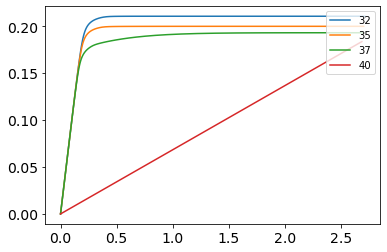

In [15]:
ages  = [32,35,37,40]

fig = plt.plot()
for age in ages:
    i = lc.T-age
    plt.plot(as_star[i,:,0],
             σs_star[i,:,0],
             label = str(age))
#plt.plot(as_star[0,:,0],as_star[0,:,0],'-')
plt.legend(loc=1)

In [44]:
## interpolate consumption function on continuous z grid 

σs= policyfunc(lc,
               as_star,
               σs_star,
               discrete = False)

Text(0, 0.5, 'infection')

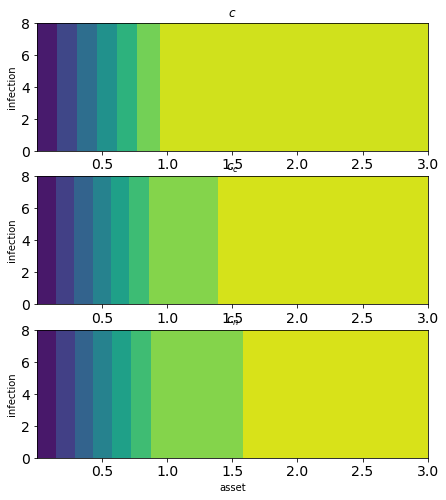

In [45]:
## plot contour for policy function 

a_grid = np.linspace(0.00001,3,20)
z_grid = np.linspace(0,8,20)
aa,zz = np.meshgrid(a_grid,z_grid)

c_stars = σ_bf(a_grid,z_grid)

fig,ax = plt.subplots(3,1,figsize=(7,8))

cp = ax[0].contourf(aa, zz,c_stars)
ax[0].set_title(r'$c$')
ax[0].set_xlabel('asset')
ax[0].set_ylabel('infection')


## Simulate the pre-pandemic history 

In [46]:
#@njit
def simulate_time_series(ifp, σ, z_idx_seq, p_income,T=400):
    """
    Simulates a time series of length T for assets/consumptions, given optimal
    consumption/demand functions.
    * z_seq is a time path for {Z_t} recorded by index, instead of its numeric value

    """
    
    # Simulate the asset path
    a = np.zeros(T)+1e-4
    c  = np.empty_like(a)
    c1 = np.empty_like(a)
    c2 = np.empty_like(a)
    
    ## simulate histories
    ζ_sim = np.random.randn(T)
    η_sim = np.random.randn(T)
    
    
    R = ifp.R
    z_val = ifp.z_val ## values of the state 
    
    
    ## permanent income shocks
    
    Γs = p_income[1:]/p_income[:-1] 
    
    for t in range(T):
        z_idx = z_idx_seq[t]
        z = z_val[z_idx]    
        S = ifp.ϕ(z,ζ_sim[t])
        Y = ifp.Y(z, η_sim[t])
        c[t] = σ(a[t], z_idx)
        c1[t],c2[t] = allocate(c[t], S = S) 
        if t<T-1:
            a[t+1] = R/Γs[t] * (a[t] - c1[t]*p_vec[0]-c2[t]*p_vec[1]) + Y
        
        
    ## multiply permanent income level 
    #c = c*p_income
    #c1 =c1*p_income
    #c2 = c2*p_income
    #a = a * p_income 
    
    return a,c,c1,c2

def simulate_time_series_new(ifp, σ, z_seq, p_income, T=400):
    """
    Simulates a time series of length T for assets/consumptions, given optimal
    consumption/demand functions.

        * ifp is an instance of IFP
        * a_star is the endogenous grid solution
        * σ_star is optimal consumption on the grid
        * z_seq is a time path for {Z_t} recorded by its numeric value (different from the previous function)

    """
    
    # Simulate the asset path
    a = np.zeros(T)+1e-4
    c = np.empty_like(a)
    c1 = np.empty_like(a)
    c2 = np.empty_like(a)
    
    ## simulate histories
    ζ_sim = np.random.randn(T)
    η_sim = np.random.randn(T)
    
    
    R = ifp.R
    #z_val = ifp.z_val ## values of the state 
    
    ## permanent income shocks
    
    Γs = p_income[1:]/p_income[:-1] 
    
    for t in range(T):
        z = z_seq[t] ## z values
        S = ifp.ϕ(z,ζ_sim[t])
        Y = ifp.Y(z, η_sim[t])
        c[t] = σ(a[t], z)
        c1[t],c2[t] = allocate(c[t], S = S) 
        if t<T-1:
            a[t+1] = R/Γs[t] * (a[t] - c1[t]*p_vec[0]-c2[t]*p_vec[1]) + Y
        
    ## multiply permanent income level 
    #c = c*p_income
    #c1 =c1*p_income
    #c2 = c2*p_income
    #a = a * p_income 
    
    return a,c,c1,c2

## now, we simulate the time-series of a cross-sectional matrix of N agents 

#@njit
def simulate_distribution(ifp, 
                          a_star, 
                          p_vec, 
                          σ_star,
                          z_mat, 
                          p_income_mat,
                          N = 3000, 
                          T = 400,
                          discrete = True):
    N_z, T_z = z_mat.shape
    
    assert N_z>=N and T_z >=T, 'history of the markov states are smaller than the simulated matrix'
    
    
    z_mat = z_mat[0:N,0:T]
    ## z_mat is a N_sim x T sized matrix that takes the simulated Markov states 
    a_mat = np.empty((N,T))
    c_mat = np.empty((N,T))
    c1_mat = np.empty((N,T))
    c2_mat = np.empty((N,T))
    
    ## get the policy function
    
    if discrete ==True:
        σ = policyfunc(ifp,
                       a_star,
                       σ_star,
                       discrete = True)  ## interpolate for discrete z index 
        for i in range (N):
            a_mat[i,:],c_mat[i,:],c1_mat[i,:], c2_mat[i,:] = simulate_time_series(ifp,
                                                                                   σ,
                                                                                   z_mat[i,:],
                                                                                   p_income_mat[i,:],
                                                                                   T = T)
    else:
        σ = policyfunc(ifp,
                       a_star,
                       σ_star,
                       discrete = False) ## interpolate for continous z value 
        for i in range (N):
            a_mat[i,:],c_mat[i,:],c1_mat[i,:], c2_mat[i,:] = simulate_time_series_new(ifp,
                                                                                      σ,
                                                                                      z_mat[i,:],
                                                                                      p_income_mat[i,:],
                                                                                      T = T)
            
    ## multiply permanent income level 
    #c_mat= np.multiply(c_mat,p_income_mat)
    #c1_mat = np.multiply(c1_mat,p_income_mat)
    #c2_mat = np.multiply(c2_mat,p_income_mat)
    #a_mat = np.multiply(a_mat,p_income_mat) 

    return a_mat,c_mat,c1_mat, c2_mat

In [47]:
## simulate a Markov sequence 

mc = MarkovChain(ifp.P)

### Simulate history of Idiosyncratic Z states 
#### (For Z to be aggregate state. We can directly copy Z for different agents) 

N = W.shape[0]  ## correspond to # of agents, the length of W matrix
N16 = W16.shape[0]  ## correspond to # of agents, the length of W matrix

T = 25        ## simulated history of time period

z_idx_mat = mc.simulate(T*N, random_state=13274).reshape([N,T])

In [48]:
## simulate a permanent income distributions 

@njit
def RWSimulate(T,
               sigma,
               init = 0.001):
    pshk_draws = sigma*np.random.randn(T)-sigma**2/2
    log_p_inc = np.empty(T)
    log_p_inc[0] = init
    for t in range(T-1):
        log_p_inc[t+1] = log_p_inc[t]+ pshk_draws[t+1]
    p_income = np.exp(log_p_inc)
    return p_income


## simulate histories of permanent income 

p_income_mat = np.empty([N,T])

for n in range(N):
    p_income_mat[n,:] = RWSimulate(T,
                                  sigma = ifp.a_p,
                                  init = 0.0001)

In [49]:
## Set the size of the preference volatility to match sub-category inequality 

ifp.a_s = 2

In [50]:
## Simulate the distribution of consumption/asset (no social network learning)

p_vec = (1,1) 
a_dist,c_dist,c1_dist,c2_dist = simulate_distribution(ifp,
                                                      a_bf_star,
                                                      p_vec,
                                                      σ_bf_star,
                                                      z_idx_mat,
                                                      p_income_mat,
                                                      N = N,
                                                      T = T,
                                                      discrete = True)

In [51]:
## aggregate history 

co_mat = np.multiply(c_dist,p_income_mat)  ## non-normalized consumption
lco_mat = np.log(co_mat)
lco_av = np.mean(lco_mat,axis = 0)

#p_av =  np.mean(p_income_mat,axis = 0)  
#lp_av = np.log(p_av)
lp_income_mat = np.log(p_income_mat)   ## permanent income level 
lp_av = np.mean(lp_income_mat,axis = 0)

#c_av = np.mean(c_dist,axis=0)
#lc_av = np.log(c_av)
lc_mat = np.log(c_dist)             ## normalized consumption
lc_av = np.mean(lc_mat,axis = 0) 

lc_sd = np.sqrt(np.diag(np.cov(lc_mat.T)))

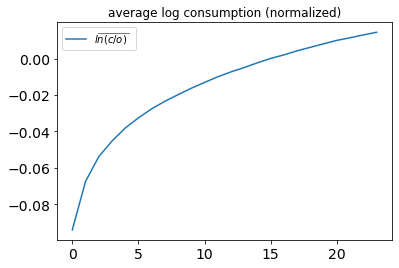

In [52]:
plt.title('average log consumption (normalized)')
plt.plot(lc_av[1:],label = r'$\widebar{ln(c/o)}$')
plt.legend(loc=2)

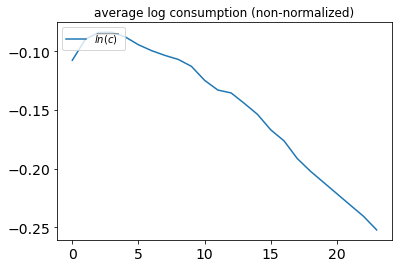

In [53]:
plt.title('average log consumption (non-normalized)')
plt.plot(lco_av[1:],label = r'$\widebar{ln(c)}$')
plt.legend(loc=2)

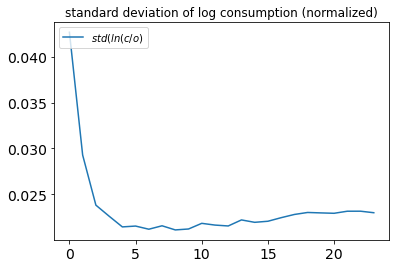

In [54]:
plt.title('standard deviation of log consumption (normalized)')
plt.plot(lc_sd[1:],label = r'$std(ln(c/o)$')
plt.legend(loc=2)

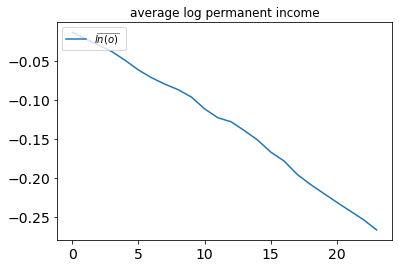

In [55]:
plt.title('average log permanent income')
plt.plot(lp_av[1:],label = r'$\widebar{ln(o)}$')
plt.legend(loc=2)

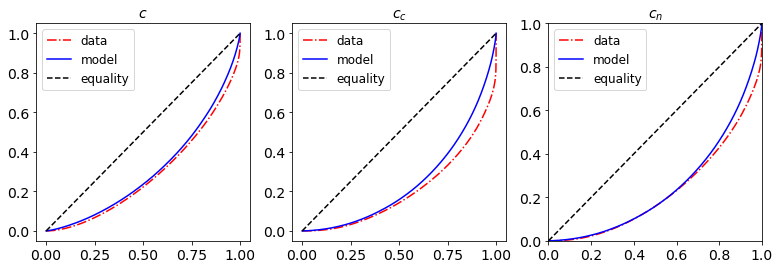

In [56]:
## get lorenz curve of the consumption inequality 

C_model = c_dist[:,-1]
C1_model = c1_dist[:,-1]
C2_model = c2_dist[:,-1]

## multiply by permanent income 
CO_model = np.multiply(c_dist[:,-1],p_income_mat[:,-1])
CO1_model = np.multiply(c1_dist[:,-1],p_income_mat[:,-1])
CO2_model = np.multiply(c2_dist[:,-1],p_income_mat[:,-1])

fc_m_vals, lc_m_vals = qe.lorenz_curve(CO_model)
fc1_m_vals, lc1_m_vals = qe.lorenz_curve(CO1_model)
fc2_m_vals, lc2_m_vals = qe.lorenz_curve(CO2_model)


fig, axs = plt.subplots(1,
                        3,
                        figsize=(13,4))

## total consumption 
axs[0].plot(fc_vals, lc_vals, 'r-.',label='data')
axs[0].plot(fc_m_vals, lc_m_vals, 'b-',label='model')
axs[0].plot(fc_vals, fc_vals, 'k--',label='equality')
axs[0].legend(fontsize=legendsize)
axs[0].set_title(r'$c$',fontsize=fontsize)
#plt.xlim([0,1])
#plt.ylim([0,1])

## conctact consumption 

## total consumption 
axs[1].plot(fc1_vals, lc1_vals, 'r-.',label='data')
axs[1].plot(fc1_m_vals, lc1_m_vals, 'b-',label='model')
axs[1].plot(fc1_vals, fc1_vals, 'k--',label='equality')
axs[1].legend(fontsize=legendsize)
axs[1].set_title(r'$c_c$',fontsize=fontsize)
#plt.xlim([0,1])
#plt.ylim([0,1])


## total consumption 
axs[2].plot(fc2_vals, lc2_vals, 'r-.',label='data')
axs[2].plot(fc2_m_vals, lc1_m_vals, 'b-',label='model')
axs[2].plot(fc2_vals, fc2_vals, 'k--',label='equality')
axs[2].legend(fontsize=legendsize)
axs[2].set_title(r'$c_n$',fontsize=fontsize)
plt.xlim([0,1])
plt.ylim([0,1])

plt.show()
fig.savefig('../graph/model/lorenz_c.jpg')

## Then, solve the model with the pandemic 



In [57]:
ifp.b_y = -0.1
ifp.b_s = -0.2

In [58]:
## Pandemic Markov 

## feed a markov tanchened from ar1
## these parameters are estimated from Covid19 cases per capita of all U.S. counties during the pandemic 

ρ, σ = (0.978,0.18)
constant = 0.13  
mc = qe.markov.approximation.tauchen(ρ, σ, b=constant, m=3, n=7)
z_ss_av = constant/(1-ρ)
z_ss_sd = σ*np.sqrt(1/(1-ρ**2))

## feed ifp with a markov matrix 
ifp.z_val, ifp.P = mc.state_values, mc.P

## some initial guesses 
k = len(ifp.s_grid)
n = len(ifp.P)
σ_init = np.empty((k, n))
for z in range(n):
    σ_init[:, z] = ifp.s_grid
a_init = np.copy(σ_init)

In [59]:
a_star, σ_star = solve_model_time_iter(ifp,a_init, σ_init)

Error at iteration 50 is 0.002146414780226813.
Error at iteration 100 is 0.0007843227956180199.
Error at iteration 150 is 0.00047768428625771797.
Error at iteration 200 is 0.0003346376274815377.
Error at iteration 250 is 0.00024637405251515254.
Error at iteration 300 is 0.0001857151048272332.
Error at iteration 350 is 0.00014212568494076372.
Error at iteration 400 is 0.00011003970810674613.
Error at iteration 450 is 8.602229155685315e-05.
Error at iteration 500 is 6.780360349101233e-05.
Error at iteration 550 is 5.382718559399091e-05.
Error at iteration 600 is 4.299909506899624e-05.
Error at iteration 650 is 3.453623319293886e-05.
Error at iteration 700 is 2.7869818949866065e-05.
Error at iteration 750 is 2.2581586592185232e-05.
Error at iteration 800 is 1.8360465712796703e-05.
Error at iteration 850 is 1.4972647404798423e-05.
Error at iteration 900 is 1.2240620717807182e-05.
Error at iteration 950 is 1.0028323529809313e-05.
Error at iteration 1000 is 8.230516299834179e-06.
Error at it

In [62]:
## interpolate consumption function on continuous z grid 
σ_= policyfunc(ifp,
               a_star,
               σ_star,
               discrete = False)

Text(0, 0.5, 'infection')

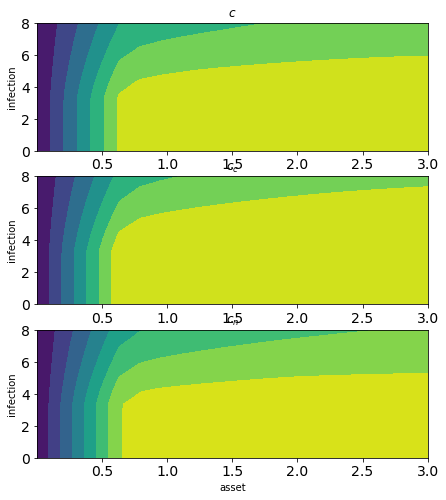

In [63]:
## plot contour for policy function 

a_grid = np.linspace(0.00001,3,20)
z_grid = np.linspace(0,8,20)
aa,zz = np.meshgrid(a_grid,z_grid)

c_stars = σ_(a_grid,z_grid)
c1_stars,c2_stars = allocate(c_stars,S = 1)

fig,ax = plt.subplots(3,1,figsize=(7,8))

cp1 = ax[0].contourf(aa, zz,c_stars)
ax[0].set_title(r'$c$')
ax[0].set_xlabel('asset')
ax[0].set_ylabel('infection')


cp2 = ax[1].contourf(aa, zz,c1_stars)
ax[1].set_title(r'$c_c$')
ax[1].set_xlabel('asset')
ax[1].set_ylabel('infection')


cp3 = ax[2].contourf(aa, zz,c2_stars)
ax[2].set_title(r'$c_n$')
ax[2].set_xlabel('asset')
ax[2].set_ylabel('infection')

## Impulse reponse to an infection shock 

In [64]:
#####################
##  update z ########
#####################

def UpdateNextPeriod(now,
                     psi,
                     alpha,
                     sigma):
    return psi*now+alpha + sigma 


In [65]:
#############################
## continous z state  #
############################

## impulse response function plots the consumption 
##    response after an unexpected +10% shock to the state $Z$ 
#@njit
def irf_(ifp,
        p_vec,    ## price vector
        σ_,
        s_init,        ## initial bank balance distribution
        z_init,        ## initial z distribution
        z_jump = 0.5,  ## shock of z to some fraction of the agents in the economy 
        fraction = 1,
        period = 5):
    
    ## parameters 
    R = ifp.R
    z_val = ifp.z_val
    eps = ifp.eps

    ## simulate impulse responses 
    N = len(s_init)
        
    ## aseet initial
    a_irf = np.empty((N,period))
    a_SS = np.empty((N,period))
    
    ## permanent income
    o_irf = np.empty((N,period))
    for n in range(N):
        n_burn = 10
        o_irf_burn = RWSimulate(period+n_burn,
                                sigma = ifp.a_p,
                                init = 0.00001)
        
        o_irf[n,:] = o_irf_burn[n_burn:]  ## burn the first 100 simulated observations  
    
    ## z state initial
    z_SS = np.tile(z_init,(period,1)).T    
    
    z_irf = np.copy(z_SS)
    cutoff_idx = np.int(N*fraction) ## the fracton of the agents shocked, all by default
    z_irf[0:cutoff_idx,0]= z_irf[0:cutoff_idx,0]*(1+z_jump)   ## all agents increase by z_jump at time t=1
    
    for t in range(period-1):
        z_irf[:,t+1] = UpdateNextPeriod(z_irf[:,t],
                                        ρ,
                                        constant,
                                        0)
    
    ## z belief state initial
    z_b_SS = z_SS
    z_b_irf = z_irf
    
    ## simulate shocks
    ζ_sim = np.random.randn(N,period)-1/2
    η_sim = np.random.randn(N,period)-1/2
    
    ## consumption responses 
    c_irf = np.empty((N,period))
    c1_irf = np.empty((N,period))
    c2_irf = np.empty((N,period))
    c_SS = np.empty((N,period))
    c1_SS = np.empty((N,period))
    c2_SS = np.empty((N,period))
    
    
    ## update initial asset/consumption
    for n in range(N):
        ## irf 
        z = z_irf[n,0]
        S = ifp.ϕ(z,ζ_sim[n,0])
        Y = ifp.Y(z, η_sim[n,0])
        a = s_init[n]+ Y
        a_irf[n,0] = a 
        c_irf[n,0] = σ_(a,z)
        c1_irf[n,0],c2_irf[n,0] = allocate(c_irf[n,0], 
                                           eps = eps,
                                           S=S) 
        ## SS
        z = z_SS[n,0]
        S = ifp.ϕ(z,ζ_sim[n,0])
        Y = ifp.Y(z, η_sim[n,0])
        a = s_init[n]+ Y
        a_SS[n,0] = a 
        c_SS[n,0] = σ_(a,z)
        c1_SS[n,0],c2_SS[n,0] = allocate(c_SS[n,0], 
                                         eps = eps,
                                         S=S) 
    
    ## fill the rest of the histories  
    for n in range(N):
        Γs = o_irf[n,1:]/o_irf[n,:-1] 
        for t in range(period-1):
            ## irf
            z = z_irf[n,t+1]
            S = ifp.ϕ(z,ζ_sim[n,t+1])
            Y = ifp.Y(z, η_sim[n,t+1])
            a = a_irf[n,t]
            a_irf[n,t+1] = R/Γs[t] * (a - c1_irf[n,t]*p_vec[0]-c2_irf[n,t]*p_vec[1]) + Y
            a_new  = a_irf[n,t+1]
            c_irf[n,t+1] = σ_(a_new,z)
            c1_irf[n,t+1],c2_irf[n,t+1] = allocate(c_irf[n,t+1], 
                                                   eps = eps,
                                                   S=S) 
            
            
            ## SS
            z = z_SS[n,t+1]
            S = ifp.ϕ(z,ζ_sim[n,t+1])
            Y = ifp.Y(z, η_sim[n,t+1])
            a = a_SS[n,t]
            a_SS[n,t+1] = R/Γs[t] * (a - c1_SS[n,t]*p_vec[0]-c2_SS[n,t]*p_vec[1]) + Y
            a_new  = a_SS[n,t+1]
            c_SS[n,t+1] = σ_(a_new,z)
            c1_SS[n,t+1],c2_SS[n,t+1] = allocate(c_SS[n,t+1], 
                                                 eps = eps,
                                                 S=S) 
            
    
    ## multiply asset/consumption by permanent income level 
    #c_irf= np.multiply(c_irf,o_irf)
    #c1_irf = np.multiply(c1_irf,o_irf)
    #c2_irf = np.multiply(c2_irf,o_irf)
    #a_irf = np.multiply(a_irf,o_irf) 
    #c_SS = np.multiply(c_SS,o_irf)
    #c1_SS = np.multiply(c1_SS,o_irf)
    #c2_SS = np.multiply(c2_SS,o_irf)
    #a_SS = np.multiply(a_SS,o_irf) 
    
    
    ## get the cross-sectional average 
    z_irf,z_b_irf = np.mean(np.log(z_irf),axis=0),np.mean(np.log(z_b_irf),axis=0)
    c_irf, c1_irf,c2_irf = np.mean(np.log(c_irf),axis=0), np.mean(np.log(c1_irf),axis=0),np.mean(np.log(c2_irf),axis=0)
    a_irf = np.mean(np.log(a_irf), axis=0)  
    
    z_SS,z_b_SS = np.mean(np.log(z_SS),axis=0),np.mean(np.log(z_b_SS),axis=0)
    c_SS, c1_SS,c2_SS = np.mean(np.log(c_SS),axis=0), np.mean(np.log(c1_SS),axis=0),np.mean(np.log(c2_SS),axis=0) 
    a_SS = np.mean(np.log(a_SS), axis=0)
    
    return z_irf, z_b_irf, a_irf, c_irf, c1_irf, c2_irf, z_SS, z_b_SS, a_SS, c_SS, c1_SS, c2_SS

In [66]:
## steady state asset and states 
s_SS_init = a_dist[:,-1]-c_dist[:,-1]
N = s_SS_init.shape[0]
z_SS_init = z_ss_av*np.ones(N)

In [67]:
## get the impulse responses
ifp.eps = 0.75
z_irf,z_b_irf,a_irf, c_irf, c1_irf,c2_irf,z_SS,z_b_SS,a_SS, c_SS, c1_SS,c2_SS = irf_(ifp,
                                                                                      p_vec,
                                                                                      σ_,
                                                                                      s_SS_init,
                                                                                      z_SS_init,
                                                                                      z_jump = 0.1,
                                                                                      fraction = 1,
                                                                                      period = 20)

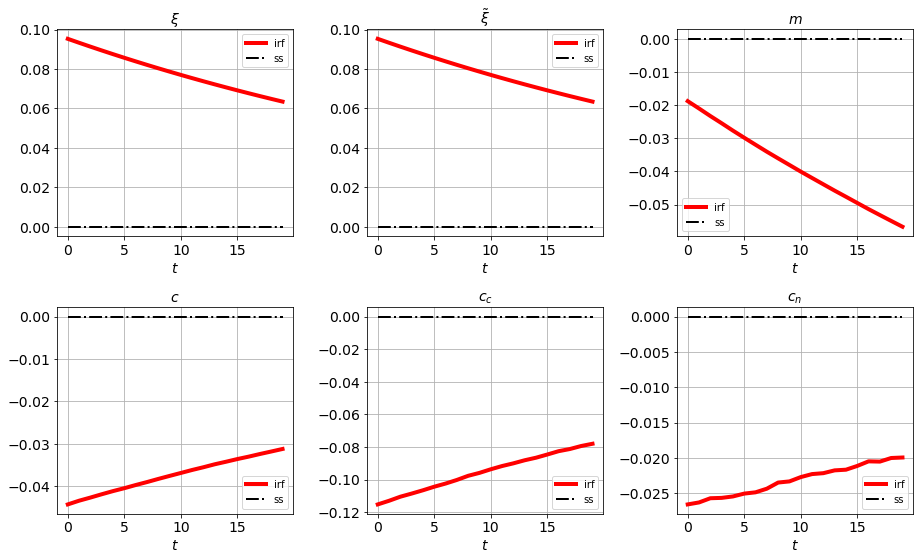

In [68]:
## plot impulses reponses

fig, axs = plt.subplots(2,3, 
                        figsize=(13, 8), 
                        facecolor='w', 
                        edgecolor='k')

irf_plot = [z_irf, z_b_irf, a_irf, c_irf, c1_irf,c2_irf]
ss_plot =  [z_SS, z_b_SS, a_SS, c_SS, c1_SS,c2_SS]

names = [r'$\xi$',r'$\tilde \xi$',r'$m$',r'$c$',r'$c_c$',r'$c_n$']

axs = axs.ravel()

for i, var in enumerate(irf_plot):
    compared_to_SS = var- ss_plot[i]  ## plot the relative differences with SS
    rebase_SS = np.zeros(len(var))    ## set SS to be zero
    axs[i].plot(compared_to_SS,
                'r-',
                lw = 4,
               label = 'irf')
    #axs[i].set_xticks(np.arange(1,len(var)+2))
    axs[i].plot(rebase_SS,
               'k-.',
               lw = 2,
               label ='ss')
    axs[i].set_title(names[i], fontsize=fontsize)
    axs[i].set_xlabel(r'$t$', fontsize=fontsize)
    axs[i].legend(loc=0)
    axs[i].grid()
fig.tight_layout(pad=1.5)
plt.savefig('../graph/model/irf_baseline.jpg')

## Simulate markov sequence of underlying state and the belief states

In [69]:
### Simulate belief based on realized state and social network connecteness 

@njit 
def UpdateBelief(belief_vec,
                weight_matrix):
    return weight_matrix@belief_vec

def UpdateBeliefDist(z_idx_mat,  ## cross-distirubiton of the underlying state
                     W,
                     z_val):      ## social influence matrix
    N,T = z_idx_mat.shape
    z_belief = np.zeros((N,T))
    
    for t in range(T):
        z_now = z_idx_mat[:,t]
        z_belief[:,t] = 0.0
        
        for i,z in enumerate(z_val):
            
            z_prior = z_now==i
            z_prior = z_prior.astype('float32')
            z_post = UpdateBelief(z_prior,
                                  W)
            z_belief[:,t] += z_post*z
            
    return z_belief     


def UpdateBeliefDistFromVal(z_mat,  ## cross-distirubiton of the underlying state
                            W):      ## social influence matrix
    N,T = z_mat.shape
    z_belief = np.zeros((N,T))
    ## get unique values of z
    z_val = np.unique(z_mat)
    
    for t in range(T):
        z_now = z_mat[:,t]
        z_belief[:,t] = 0.0
        
        for i,z in enumerate(z_val):
            
            z_prior = z_now==z
            z_prior = z_prior.astype('float32')
            z_post = UpdateBelief(z_prior,
                                  W)
            z_belief[:,t] += z_post*z
            
    return z_belief     

@njit
def discrete2continuous(z_idx_mat,
                       z_val):
    N,T = z_idx_mat.shape
    z_mat = np.zeros((N,T))
    
    for i in range(z_mat.shape[0]):
        for j in range(z_mat.shape[1]):
            z_idx = z_idx_mat[i,j]
            z_mat[i,j] = z_val[z_idx]
    return z_mat

In [70]:
## simulate belief distribution 

z_val = ifp.z_val  ## get the vector of the values of z grid

## generated the distribution of beliefs based on simulated history of z states

z_belief = UpdateBeliefDist(z_idx_mat,
                            W,
                            z_val)


## convert the markov matrix of index to a matrix of values of z

z_mat = discrete2continuous(z_idx_mat,
                            z_val)

In [71]:
## with social network learning 

pa_dist,pc_dist,pc1_dist,pc2_dist = simulate_distribution(ifp, 
                                                          a_star, 
                                                          p_vec, 
                                                          σ_star,
                                                          z_belief,
                                                          p_income_mat,
                                                          N = N,
                                                          T = T,
                                                          discrete = False)

In [72]:
## compute cross-sectional summary statistics

## average pattern

lc_dist = np.log(c_dist) 
lc_av = np.mean(lc_dist,axis = 0)

lpc_dist = np.log(pc_dist) 
lpc_av = np.mean(lpc_dist,axis = 0)

## correlation
lc_sd = np.sqrt(np.diag(np.cov(lc_dist.T)))
lpc_sd = np.sqrt(np.diag(np.cov(lpc_dist.T)))

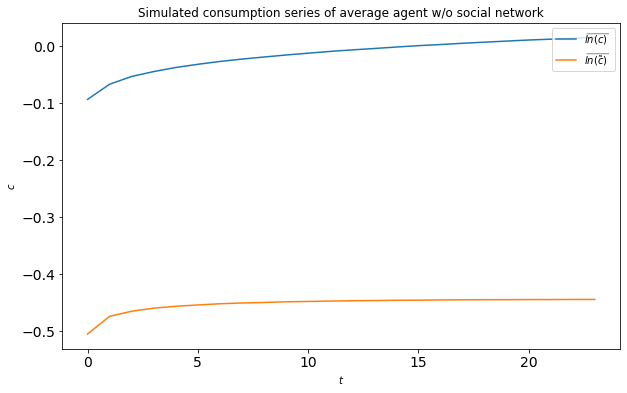

In [73]:
## plot the average consumption 

fig, ax = plt.subplots(figsize = (10,6))
ax.plot(lc_av[1:],label = r'$\widebar{ln(c)}$')
ax.plot(lpc_av[1:],label = r'$\widebar{ln(\tilde c)}$')
ax.set(xlabel=r'$t$')
ax.set(ylabel=r'$c$')
plt.title('Simulated consumption series of average agent w/o social network')
plt.legend(loc=1)
plt.show()

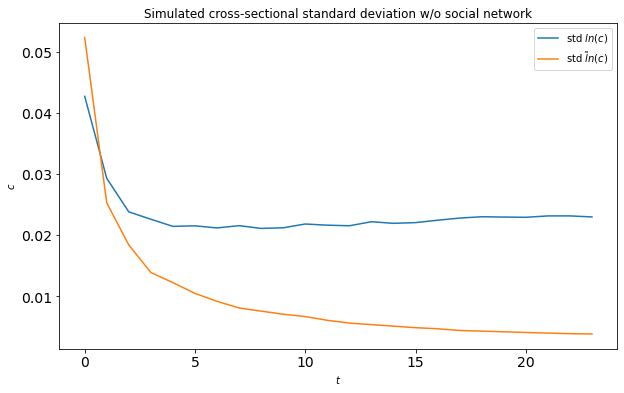

In [74]:
## plot the cross-sectional correlation of non-contact-based consumption

fig, ax = plt.subplots(figsize = (10,6))
ax.plot(lc_sd[1:],label = r'std $ln(c)$')
ax.plot(lpc_sd[1:],label = r'std $\tilde ln(c)$')
ax.set(xlabel=r'$t$')
ax.set(ylabel=r'$c$')
plt.title('Simulated cross-sectional standard deviation w/o social network')
plt.legend(loc=1)
plt.show()

## Impulse response with social network learning 

- plots the impulse response of average beliefs about the states and consumption responses after a one-time exogeous jump from low infection to high state of all agents

In [75]:
################################
## social network learning ##
###############################

def irf_b(ifp,
        p_vec,    ## price vector
        σ_,
        s_init,        ## initial bank balance distribution
        z_init,        ## initial z distribution
        z_jump = 0.5,  ## shock of z to some fraction of the agents in the economy 
        fraction = 1,
        period = 5,
        where = (0,1),        ## fraction of nodes to be shocked 
        weight = W):
    
    ## parameters 
    R = ifp.R
    z_val = ifp.z_val
    eps = ifp.eps
    
    ## simulate impulse responses 
    N = len(s_init)
    
    ## degrees 
    degree = np.sum(weight,axis = 0)
    rank_idx = np.flip(degree.argsort())  ## descending sorted index, e.g. the first element is the index of smallest influence
    lb,ub = where
    cut_lb,cut_ub = np.int(N*lb),np.int(N*ub),
    shocked_idx = rank_idx[cut_lb:cut_ub-1]  ### the index that to be shocked 
        
    ## aseet initial
    a_irf = np.empty((N,period))
    a_SS = np.empty((N,period))
    
    ## permanent income
    o_irf = np.empty((N,period))
    for n in range(N):
        n_burn = 10
        o_irf_burn = RWSimulate(period+n_burn,
                                sigma = ifp.a_p,
                                init = 0.00001)
        
        o_irf[n,:] = o_irf_burn[n_burn:]  ## burn the first 100 simulated observations  
    
    ## z state initial
    z_SS = np.tile(z_init,(period,1)).T    
    
    z_irf = np.copy(z_SS)
    z_irf_temp = z_irf[:,0]
    z_irf_temp[shocked_idx] = z_irf_temp[shocked_idx]*(1+z_jump)
    z_irf[:,0]= z_irf_temp   ## all agents increase by i state 
    
    for t in range(period-1):
        z_irf[:,t+1] = UpdateNextPeriod(z_irf[:,t],
                                        ρ,
                                        constant,
                                        0)
    
    ## z belief state initial
    z_b_SS = UpdateBeliefDistFromVal(z_SS,
                                     W)
    z_b_irf = UpdateBeliefDistFromVal(z_irf,
                                      W)
    
    ## simulate shocks
    ζ_sim = np.random.randn(N,period)-1/2
    η_sim = np.random.randn(N,period)-1/2
    
    ## consumption responses 
    c_irf = np.empty((N,period))
    c1_irf = np.empty((N,period))
    c2_irf = np.empty((N,period))
    c_SS = np.empty((N,period))
    c1_SS = np.empty((N,period))
    c2_SS = np.empty((N,period))
    
    
    ## update initial asset/consumption
    for n in range(N):
        ## irf 
        z_b = z_b_irf[n,0]  # perceived state 
        z = z_irf[n,0]      ## true state 
        S = ifp.ϕ(z_b,ζ_sim[n,0])  ## preference hsock depends on believed state 
        Y = ifp.Y(z, η_sim[n,0]) ## income depends on true state 
        a = s_init[n]+ Y   
        a_irf[n,0] = a 
        c_irf[n,0] = σ_(a,z_b)  ## consumption depends on the perceived state 
        c1_irf[n,0],c2_irf[n,0] = allocate(c_irf[n,0],
                                           eps = eps,
                                           S=S)
        
        ## SS
        z_b = z_b_SS[n,0]   # perceived state 
        z = z_SS[n,0]       ## true state 
        S = ifp.ϕ(z_b,ζ_sim[n,0])  ## preference hsock depends on believed state 
        Y = ifp.Y(z, η_sim[n,0]) ## income depends on true state 
        a = s_init[n]+ Y   ## consumption depends on the perceived state 
        a_SS[n,0] = a 
        c_SS[n,0] = σ_(a,z_b)
        c1_SS[n,0],c2_SS[n,0] = allocate(c_SS[n,0],
                                         eps = eps,
                                         S=S)
    
    ## fill the rest of the histories  
    for n in range(N):
        Γs = o_irf[n,1:]/o_irf[n,:-1] 
        for t in range(period-1):
            ## irf
            z_b = z_b_irf[n,t+1] ## perceived state 
            z = z_irf[n,t+1]  ## true state 
            S = ifp.ϕ(z_b,ζ_sim[n,t+1])  ## preference hsock depends on believed state 
            Y = ifp.Y(z, η_sim[n,t+1]) ## perception goes to the consumption decision
            a = a_irf[n,t]  ## truth goes to law of motion
            a_irf[n,t+1] = R/Γs[t] * (a - c1_irf[n,t]*p_vec[0]-c2_irf[n,t]*p_vec[1]) + Y  
            a_new  = a_irf[n,t+1]
            c_irf[n,t+1] = σ_(a_new,z_b)
            c1_irf[n,t+1],c2_irf[n,t+1] = allocate(c_irf[n,t+1], 
                                                   eps = eps,
                                                   S=S)
            
            ## SS
            z_b = z_b_SS[n,t+1]
            z = z_SS[n,t+1]
            S = ifp.ϕ(z_b,ζ_sim[n,t+1])  ## preference hsock depends on believed state 
            Y = ifp.Y(z, η_sim[n,t+1])
            a = a_SS[n,t]
            a_SS[n,t+1] = R/Γs[t] * (a - c1_SS[n,t]*p_vec[0]-c2_SS[n,t]*p_vec[1]) + Y
            a_new  = a_SS[n,t+1]
            c_SS[n,t+1] = σ_(a_new,z_b)
            c1_SS[n,t+1],c2_SS[n,t+1] = allocate(c_SS[n,t+1], 
                                                 eps = eps,
                                                 S=S)
            
    
    ## multiply asset/consumption by permanent income level 
    #c_irf= np.multiply(c_irf,o_irf)
    #c1_irf = np.multiply(c1_irf,o_irf)
    #c2_irf = np.multiply(c2_irf,o_irf)
    #a_irf = np.multiply(a_irf,o_irf) 
    #c_SS = np.multiply(c_SS,o_irf)
    #c1_SS = np.multiply(c1_SS,o_irf)
    #c2_SS = np.multiply(c2_SS,o_irf)
    #a_SS = np.multiply(a_SS,o_irf) 
     
    
    ## get the cross-sectional average 
    z_irf,z_b_irf = np.mean(np.log(z_irf),axis=0),np.mean(np.log(z_b_irf),axis=0)
    c_irf, c1_irf,c2_irf = np.mean(np.log(c_irf),axis=0), np.mean(np.log(c1_irf),axis=0),np.mean(np.log(c2_irf),axis=0)
    a_irf = np.mean(np.log(a_irf), axis=0)  
    
    z_SS,z_b_SS = np.mean(np.log(z_SS),axis=0),np.mean(np.log(z_b_SS),axis=0)
    c_SS, c1_SS,c2_SS = np.mean(np.log(c_SS),axis=0), np.mean(np.log(c1_SS),axis=0),np.mean(np.log(c2_SS),axis=0) 
    a_SS = np.mean(np.log(a_SS), axis=0)
    
    return z_irf, z_b_irf, a_irf, c_irf, c1_irf, c2_irf, z_SS, z_b_SS, a_SS, c_SS, c1_SS, c2_SS

In [76]:
## steady state asset and states 
s_SS_init = a_dist[:,-1]-c_dist[:,-1]
N = s_SS_init.shape[0]
z_SS_init = z_ss_av*np.ones(N)

In [77]:
## get the impulse responses

z_irf,z_b_irf,a_irf, c_irf, c1_irf,c2_irf,z_SS,z_b_SS,a_SS, c_SS, c1_SS,c2_SS = irf_b(ifp,
                                                                                    p_vec,
                                                                                    σ_,
                                                                                    s_SS_init,
                                                                                    z_SS_init,
                                                                                    z_jump = 0.1,
                                                                                    where = (0,0.33),
                                                                                    period = 20,
                                                                                    weight = W)

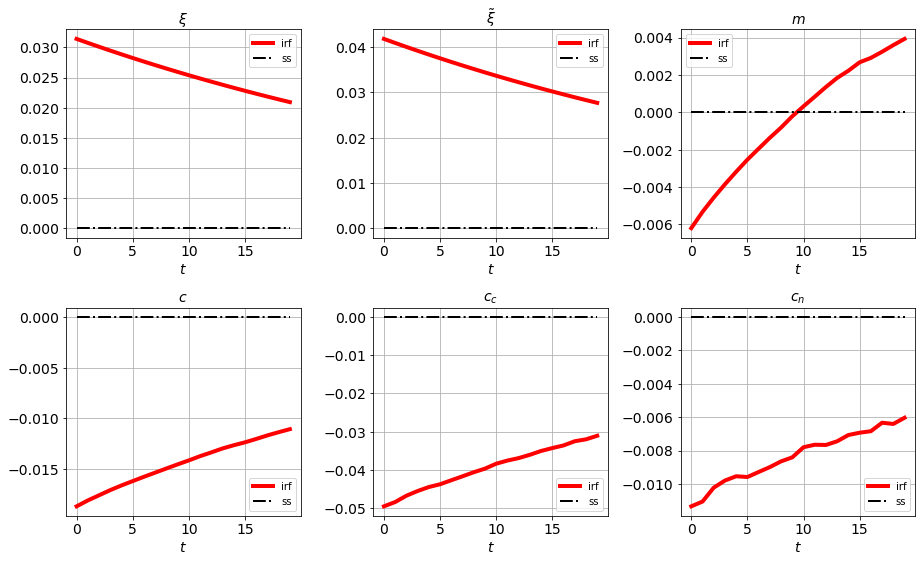

In [78]:
## plot impulses reponses

fig, axs = plt.subplots(2,3, 
                        figsize=(13, 8), 
                        facecolor='w', 
                        edgecolor='k')

irf_plot = [z_irf, z_b_irf, a_irf, c_irf, c1_irf,c2_irf]
ss_plot =  [z_SS, z_b_SS, a_SS, c_SS, c1_SS,c2_SS]

names = [r'$\xi$',r'$\tilde \xi$',r'$m$',r'$c$',r'$c_c$',r'$c_n$']

axs = axs.ravel()

for i, var in enumerate(irf_plot):
    compared_to_SS = var- ss_plot[i]  ## plot the relative differences with SS
    rebase_SS = np.zeros(len(var))    ## set SS to be zero
    axs[i].plot(compared_to_SS,
                'r-',
                lw = 4,
               label = 'irf')
    axs[i].plot(rebase_SS,
               'k-.',
               lw = 2,
               label ='ss')
    axs[i].set_title(names[i], fontsize=fontsize)
    axs[i].set_xlabel(r'$t$',fontsize = fontsize)
    axs[i].legend(loc= 0)
    axs[i].grid()
fig.tight_layout(pad=1.4)

### IRF w/o social network influence 

In [81]:
## Identity matrix 

Identity = np.eye(N)  ## no social network is when the weight matrix takes an identity matrix


## no social network

## get the impulse responses when there is no social network influence 
z_irf0,z_b_irf0,a_irf0, c_irf0, c1_irf0,c2_irf0,z_SS0,z_b_SS0,a_SS0, c_SS0, c1_SS0,c2_SS0 = irf_b(ifp,
                                                                                                    p_vec,
                                                                                                    σ_,
                                                                                                    s_SS_init,
                                                                                                    z_SS_init,
                                                                                                    z_jump = 0.1,
                                                                                                    where = (0,0.33),
                                                                                                    period = 20,
                                                                                                    weight = Identity)

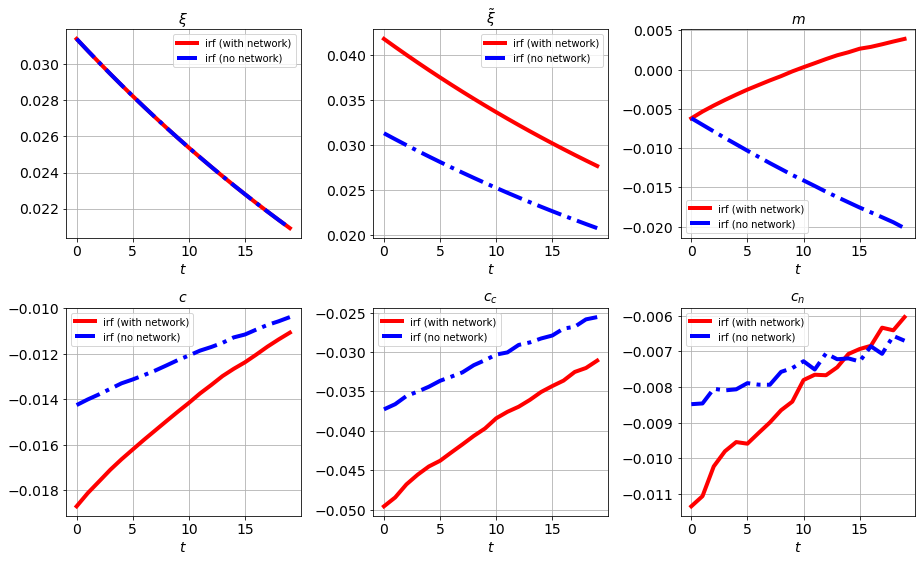

In [82]:
## plot impulses reponses

fig, axs = plt.subplots(2,3, 
                        figsize=(13, 8), 
                        facecolor='w', 
                        edgecolor='k')

irf0_plot = [z_irf0, z_b_irf0, a_irf0, c_irf0, c1_irf0,c2_irf0]
ss0_plot =  [z_SS0, z_b_SS0, a_SS0, c_SS0, c1_SS0,c2_SS0]

irf_plot = [z_irf, z_b_irf, a_irf, c_irf, c1_irf,c2_irf]
ss_plot =  [z_SS, z_b_SS, a_SS, c_SS, c1_SS,c2_SS]

names = [r'$\xi$',r'$\tilde \xi$',r'$m$',r'$c$',r'$c_c$',r'$c_n$']


axs = axs.ravel()

for i, var in enumerate(irf_plot):
    ## with social network 
    compared_to_SS = var- ss_plot[i]  ## plot the relative differences with SS
    rebase_SS = np.zeros(len(var))    ## set SS to be zero
    
    compared_to_SS0 = irf0_plot[i]- ss0_plot[i]  ## plot the relative differences with SS
    rebase_SS0 = np.zeros(len(var))    ## set SS to be zero
    
    axs[i].plot(compared_to_SS,
                'r-',
                lw = 4,
               label = 'irf (with network)')
    #axs[i].plot(rebase_SS,
    #          '-.',
    #           lw = 2,
    #           label ='ss')
    # without social network 
    axs[i].plot(compared_to_SS0,
               'b-.',
               lw = 4,
               label ='irf (no network)')
    #axs[i].plot(rebase_SS0,
    #           '-.',
    #           lw = 2,
    #           label ='ss (no network)')
        
    axs[i].set_title(names[i], fontsize=fontsize)
    axs[i].set_xlabel(r'$t$', fontsize=fontsize)
    axs[i].legend(loc= 0)
    axs[i].grid()
fig.tight_layout(pad=1.4)
plt.savefig('../graph/model/irf_social.jpg')

### IRF depending on where the shocks hit 

In [83]:
wheres = [(0,0.33),
         (0.33,0.66),
        (0.66,0.99)
         ]
z_irf_list, z_b_irf_list, a_irf_list, c_irf_list, c1_irf_list,c2_irf_list = [],[],[],[],[],[]
z_SS_list, z_b_SS_list, a_SS_list, c_SS_list, c1_SS_list,c2_SS_list = [],[],[],[],[],[]


for i,where in enumerate(wheres):
    ## get the impulse responses
    z_irf,z_b_irf,a_irf, c_irf, c1_irf,c2_irf,z_SS,z_b_SS,a_SS, c_SS, c1_SS,c2_SS = irf_b(ifp,
                                                                                        p_vec,
                                                                                        σ_,
                                                                                        s_SS_init,
                                                                                        z_SS_init,
                                                                                        z_jump = 0.1,
                                                                                        where = where,
                                                                                        period = 20,
                                                                                        weight = W) 
    z_irf_list.append(z_irf)
    z_b_irf_list.append(z_b_irf)
    a_irf_list.append(a_irf)
    c_irf_list.append(c_irf)
    c1_irf_list.append(c1_irf)
    c2_irf_list.append(c2_irf)
    
    z_SS_list.append(z_SS)
    z_b_SS_list.append(z_b_SS)
    a_SS_list.append(a_SS)
    c_SS_list.append(c_SS)
    c1_SS_list.append(c1_SS)
    c2_SS_list.append(c2_SS)

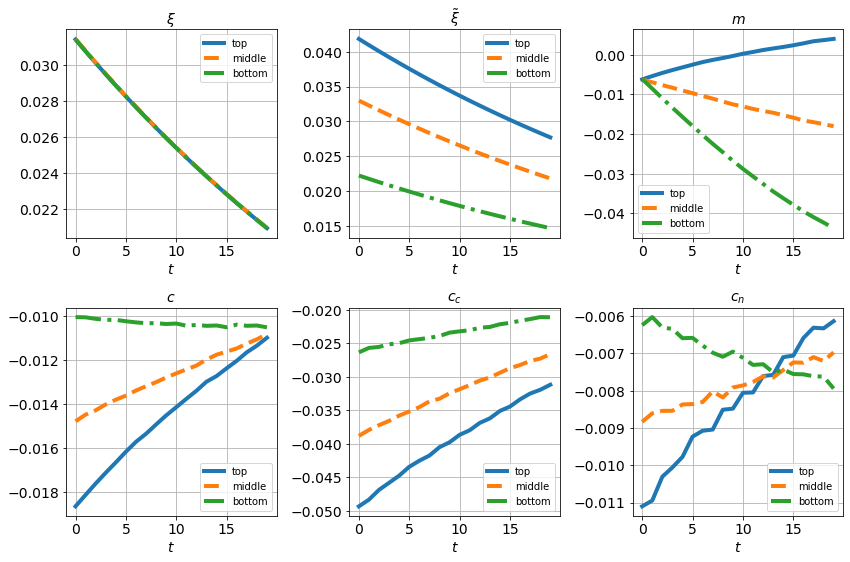

In [84]:
## plot impulses reponses

labels = ['top','middle','bottom']

fig, axs = plt.subplots(2,3, 
                        figsize=(12, 8), 
                        facecolor='w', 
                        edgecolor='k')

irf_list_plot = [z_irf_list, z_b_irf_list, a_irf_list, c_irf_list, c1_irf_list,c2_irf_list]
#ss_plot =  [z_SS, z_b_SS, a_SS, c_SS, c1_SS,c2_SS]
ss_list_plot = [z_SS_list, z_b_SS_list, a_SS_list, c_SS_list, c1_SS_list,c2_SS_list]




names = [r'$\xi$',r'$\tilde \xi$',r'$m$',r'$c$',r'$c_c$',r'$c_n$']
lps = ['-','--','-.']



axs = axs.ravel()

for i, var in enumerate(irf_list_plot):
    for s in range(len(labels)):
        compared_to_SS = var[s]- ss_list_plot[i][s]  ## plot the relative differences with SS
        rebase_SS = np.zeros(len(var[s]))    ## set SS to be zero
        axs[i].plot(compared_to_SS,
                    lps[s],
                    lw = 4,
                   label = labels[s])
    #axs[i].plot(rebase_SS,
    #           'r-.',
    #           lw = 2,
    #           label ='ss')
    axs[i].set_title(names[i],fontsize=fontsize)
    axs[i].set_xlabel(r'$t$',fontsize=fontsize)
    axs[i].legend(loc= 0)
    axs[i].grid()
fig.tight_layout(pad=1.4)
plt.savefig('../graph/model/irf_where.jpg')

### IRF depending on the EOS

In [85]:
eps_vals = np.array([0.75,0.99,1.5])

z_irf_list, z_b_irf_list, a_irf_list, c_irf_list, c1_irf_list,c2_irf_list = [],[],[],[],[],[]
z_SS_list, z_b_SS_list, a_SS_list, c_SS_list, c1_SS_list,c2_SS_list = [],[],[],[],[],[]


for i,eps in enumerate(eps_vals):
    ifp.eps  = eps 
    z_irf,z_b_irf,a_irf, c_irf, c1_irf,c2_irf,z_SS,z_b_SS,a_SS, c_SS, c1_SS,c2_SS = irf_b(ifp,
                                                                                        p_vec,
                                                                                        σ_,
                                                                                        s_SS_init,
                                                                                        z_SS_init,
                                                                                        z_jump = 0.1,
                                                                                        where = (0,0.33),
                                                                                        period = 20,
                                                                                        weight = W)
    z_irf_list.append(z_irf) 
    z_b_irf_list.append(z_b_irf)
    a_irf_list.append(a_irf)
    c_irf_list.append(c_irf)
    c1_irf_list.append(c1_irf)
    c2_irf_list.append(c2_irf)
    
    z_SS_list.append(z_SS) 
    z_b_SS_list.append(z_b_SS)
    a_SS_list.append(a_SS)
    c_SS_list.append(c_SS)
    c1_SS_list.append(c1_SS)
    c2_SS_list.append(c2_SS)

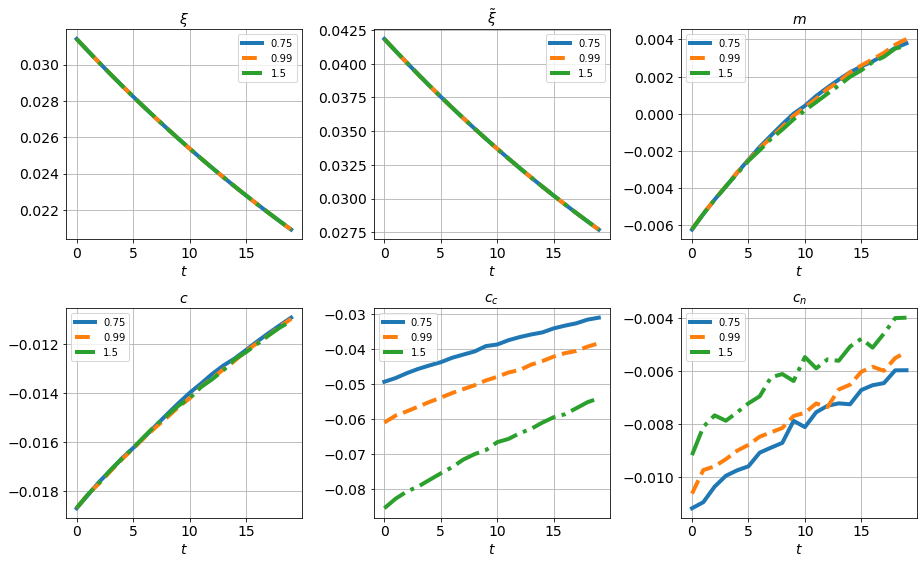

In [86]:
## plot impulses reponses


fig, axs = plt.subplots(2,3, 
                        figsize=(13, 8), 
                        facecolor='w', 
                        edgecolor='k')

irf_list_plot = [z_irf_list, z_b_irf_list, a_irf_list, c_irf_list, c1_irf_list,c2_irf_list]
ss_list_plot = [z_SS_list, z_b_SS_list, a_SS_list, c_SS_list, c1_SS_list,c2_SS_list]


names = [r'$\xi$',r'$\tilde \xi$',r'$m$',r'$c$',r'$c_c$',r'$c_n$']
lps = ['-','--','-.']



axs = axs.ravel()

for i, var in enumerate(irf_list_plot):
    for s,eps in enumerate(eps_vals):
        compared_to_SS = var[s]- ss_list_plot[i][s]  ## plot the relative differences with SS
        rebase_SS = np.zeros(len(var[s]))    ## set SS to be zero
        axs[i].plot(compared_to_SS,
                    lps[s],
                    lw = 4,
                   label = str(eps))
        axs[i].set_title(names[i],fontsize=fontsize)
        axs[i].set_xlabel(r'$t$',fontsize=fontsize)
        axs[i].legend(loc= 0)
        axs[i].grid()
        
fig.tight_layout(pad=1.3)
plt.savefig('../graph/model/irf_eos.jpg')

### IRF of different social network structure 

In [87]:
## weight matrix 

W_list = [W,W16]

z_irf_list, z_b_irf_list, a_irf_list, c_irf_list, c1_irf_list,c2_irf_list = [],[],[],[],[],[]
z_SS_list, z_b_SS_list, a_SS_list, c_SS_list, c1_SS_list,c2_SS_list = [],[],[],[],[],[]

ifp.eps = 0.75

for i,wt_mat in enumerate(W_list):
    ## nb of agents differ in 2016 and 2019
    ## need to adjust the matrix size 
    N_now = wt_mat.shape[0]    
    ss_SS_init_now = s_SS_init[0:N_now-1]
    z_SS_init_now = z_SS_init[0:N_now-1]
    
    # generate impulse responses 
    z_irf,z_b_irf,a_irf, c_irf, c1_irf,c2_irf,z_SS,z_b_SS,a_SS, c_SS, c1_SS,c2_SS = irf_b(ifp,
                                                                                        p_vec,
                                                                                        σ_,
                                                                                        s_SS_init,
                                                                                        z_SS_init,
                                                                                        z_jump = 0.1,
                                                                                        where = (0,0.33),
                                                                                        period = 20,
                                                                                        weight = wt_mat)
    z_irf_list.append(z_irf) 
    z_b_irf_list.append(z_b_irf)
    a_irf_list.append(a_irf)
    c_irf_list.append(c_irf)
    c1_irf_list.append(c1_irf)
    c2_irf_list.append(c2_irf)
    
    z_SS_list.append(z_SS) 
    z_b_SS_list.append(z_b_SS)
    a_SS_list.append(a_SS)
    c_SS_list.append(c_SS)
    c1_SS_list.append(c1_SS)
    c2_SS_list.append(c2_SS)

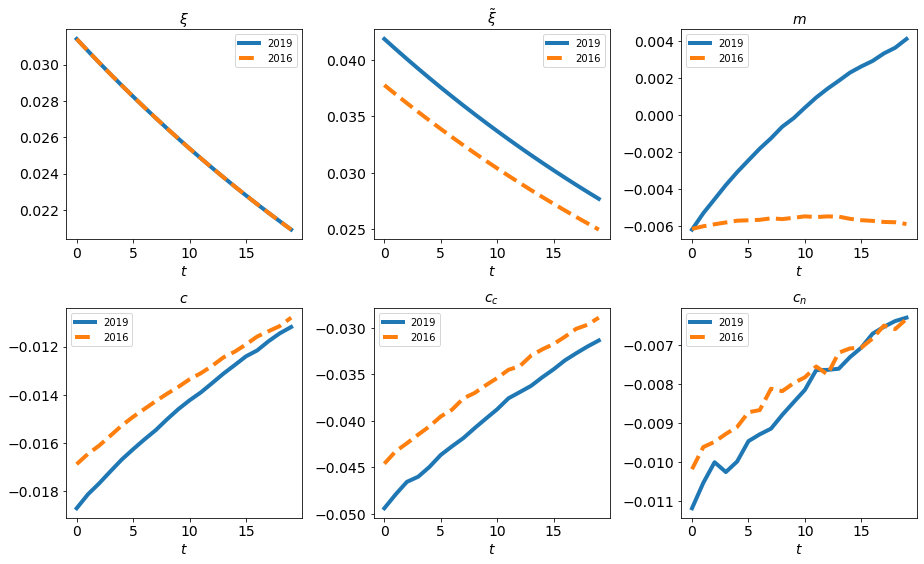

In [89]:
## plot impulses reponses


fig, axs = plt.subplots(2,3, 
                        figsize=(13, 8), 
                        facecolor='w', 
                        edgecolor='k')

irf_list_plot = [z_irf_list, z_b_irf_list, a_irf_list, c_irf_list, c1_irf_list,c2_irf_list]
ss_list_plot = [z_SS_list, z_b_SS_list, a_SS_list, c_SS_list, c1_SS_list,c2_SS_list]


names = [r'$\xi$',r'$\tilde \xi$',r'$m$',r'$c$',r'$c_c$',r'$c_n$']
lps = ['-','--','-.']
w_names = ['2019','2016']


axs = axs.ravel()

for i, var in enumerate(irf_list_plot):
    for s,wt_mat in enumerate(W_list):
        compared_to_SS = var[s]- ss_list_plot[i][s]  ## plot the relative differences with SS
        rebase_SS = np.zeros(len(var[s]))    ## set SS to be zero
        axs[i].plot(compared_to_SS,
                    lps[s],
                    lw = 4,
                   label = w_names[s])
        axs[i].set_title(names[i],fontsize=fontsize)
        axs[i].set_xlabel(r'$t$',fontsize=fontsize)
        axs[i].legend(loc= 0)
        axs[i].grid()
        
fig.tight_layout(pad=1.3)
plt.savefig('../graph/model/irf_network.jpg')